In [64]:
import numpy as np
import matplotlib.pyplot as plt
import env_functions as ef
from rl_utils import running_mean 

%matplotlib inline
# set seed for pseudorandom number generation -- make sure our trajectories look the same
np.random.seed(123)

from importlib import reload

# Fundamental Building Blocks of the Reinforcement Learning Problem

A reinforcement learning problem is one where we are interested in how an agent learns from its interaction with the environment. 

To start, we will focus on what makes up the environment and what controls its responses to the agent. 

<img src="RL_env.png" width="500"/>

States of the environment can be either discrete or continuous. Here we will just focus discrete environments. 

Moves between states are made according to a state transition function, $\mathcal{P}^{a}_{ss'}$, which specifies the probability of transitioning from state $s$ to state $s'$ as a consequence of taking action $a$. 

As a consequence of moves between states, the environment also gives a numerical reward signal. In many problems, reward is 0 until the very end (i.e. many steps without any feedback at all).

We will use the following gridworld as an example, and write some code to turn this schematic into an environment we can interact with. 
<img src="gridworld_.png" width="500"/>

# Trackworld -- a linear gridworld
<img src="trackworld.png" width="500"/>

In [65]:
class TrackWorld(object):
    def __init__(self, n_states=10): 
        self.n_states   = n_states
        self.all_states = np.arange(self.n_states)
        
        self.actions = {'Left':0, 'Right':1}
        self.n_acts  = len(self.actions)
        
        self.start    = 0 # start at position (1,1)
        self.terminal = self.n_states-1 # at position (5,5) episode ends
        self.done     = False
        
        self.P       = self.transition_function()
    
        self.R       = self.reward_function() 
        
    def transition_function(self):
        P = np.zeros((self.n_states, self.n_states, self.n_acts))
        # add transitions between neighbouring states 
        for i in range(1, self.n_states):
            P[i, (i-1), 0] = 1 # left moves
        for i in range(0,self.n_states-1):
            P[i, (i+1), 1] = 1 # right moves

        # ALTERNATIVELY
        # self.P[list(range(1, self.n_states)), list(range(0, self.n_states-1)), 0] = 1 #left
        # self.P[list(range(0, self.n_states-1)), list(range(1, self.n_states)), 1] = 1 #right
        
        # what happens in the end states? 
        P[0,0,0] = 1
        P[self.terminal,self.terminal,1]=1
        return P
    
    def reward_function(self):
        R = np.zeros(self.n_states)
        R[self.terminal] = 10
        return R 
        
    def step(self,state,action):
        if action not in self.actions.keys():  # check if move is valid
            raise Exception('Agent has tried an invalid action!')
        else:
            transition_probs = self.P[state, :, self.actions[action]]
            next_state = np.random.choice(self.all_states, p=transition_probs)
            reward = self.R[state]
            if state == self.terminal:
                self.done = True
        return next_state, reward, self.done 

In [66]:
# make an instance of trackworld
tw = TrackWorld()

# test a state an action and make sure it does what it's supposed to do 
state = 5
action= 'Right'
next_state, reward, is_done = tw.step(state,action)
print(f"State {state} / Action {action} => State {next_state} / Reward {reward}")

State 5 / Action Right => State 6 / Reward 0.0


## Adding another dimension to Trackworld: Gridworld

Here we have added multiple rows. For simplicity let's do 5 rows and 5 columns = 25 states total. This is enough to do interesting things, but not so many that it's hard to keep track of what's going on with state transitions. 

This also adds two more possible moves: "Up" and "Down". For the transition function, we have a tensor of size: 
(number of states, number of states, number of actions). The first dimension reflects the possible states we could be in currently, the second dimension reflects the states we could move into, and the third dimension represents the actions we could take. Note that this ordering is not fixed. We can slice the tensor in any way that makes sense. 

In [67]:
class MyFirstGridworld(object):
    def __init__(self, n_rows=5, n_cols=5): 
        self.rows    = n_rows
        self.cols    = n_cols
        self.shape   = (n_rows,n_cols)
        
        self.n_states   = self.rows*self.cols
        self.all_states = np.arange(self.n_states)
        self.obstacles  = [13, 14, 15, 18]
        
        self.actions = {'Down':0, 'Up':1, 'Right':2, 'Left':3}
        self.n_acts  = len(self.actions)
        
        self.start    = 0 # start at position (1,1)
        self.state    = self.start 
        self.terminal = 24 # at position (5,5) episode ends
        self.done     = False
        
        self.P       = self.transition_function()
    
        self.R       = self.reward_function()
        
    def transition_function(self):
        P = np.zeros((self.n_states, self.n_states, self.n_acts))
        
        # add transitions between neighbouring states 
        P[list(range(0, self.n_states-self.cols)), list(range(self.cols, self.n_states)), 0] = 1 #down
        P[list(range(self.cols, self.n_states)), list(range(0, self.n_states-self.cols)), 1] = 1 #up
        P[list(range(0, self.n_states-1)), list(range(1, self.n_states)), 2] = 1 #right
        P[list(range(1, self.n_states)), list(range(0, self.n_states-1)), 3] = 1 #left
        
        # remove transitions from non-adjacent states like 5-6
        east_endlines = list(range(self.cols-1,self.n_states-self.cols,self.cols))
        west_endlines = [x+1 for x in east_endlines]
        P[east_endlines, west_endlines, 2] = 0	# remove transitions at the end of the grid
        P[west_endlines, east_endlines, 3] = 0
        
        # remove transitions into/from obstacles with any action
        for i in range(self.n_acts):
            P[:, self.obstacles, i] = 0  	# remove transitions into obstacles
            P[self.obstacles, :, i] = 0  	# remove transitions from obstacles
            P[self.terminal, :, i] = 0  	# remove transitions from terminal states
            
        # transitions back to self for states where any other step has been removed
        for i in range(self.n_states):
            for j in range(self.n_acts):
                if sum(P[i,:,j])==0:
                    P[i,i,j]=1
        return P
    
    def reward_function(self):
        R = np.ones(self.n_states)*(-0.01) # -1 penalizing step everywhere but the final state
        R[self.terminal] = 10
        return R 
        
    def step(self,action):
        if action not in self.actions.keys():  # check if move is valid
            raise Exception('Agent has tried an invalid action!')
        else:
            transition_probs = self.P[self.state, :, self.actions[action]]
            next_state = np.random.choice(self.all_states, p=transition_probs)
            if self.state == self.terminal:
                self.done = True
            else:
                self.state = next_state
            
        return next_state, reward, self.done 

In [68]:
# new instance of gridworld
gw = MyFirstGridworld(n_rows=5, n_cols=5)

In [69]:
action= 'Down'
print(f"State {gw.state} / Action {action} => State {gw.step(action)}")

State 0 / Action Down => State (5, 0.0, False)


# Import Premade Gridworld from file 

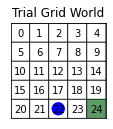

Rewards Function:
 [-0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01
 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01
 10.  ]
Transition Matrix for State 22:
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]


In [89]:
n_rows, n_cols = 5, 5
step_penalization = -0.01

gw_open = ef.GridWorld(rows=n_rows,cols=n_cols,
                  #obstacles=[(2,2),(2,3),(2,4),(3,2)], 
                  rewards={(4,4):10},
                  terminals=[(4,4)],
                  step_penalization=step_penalization,
                  actionlist=['Down','Up','Right','Left'],
                  view_labels=True
                 )

print('Rewards Function:\n', gw_open.R)

print(f'Transition Matrix for State {gw_open.state}:\n', gw.P[:,gw_open.state,:])

In [90]:
## take some steps in the environment
original_state = gw_open.state
action_name = 'Down'
action_index = gw_open.action_list.index(action_name)
updated_state, reward, done, info = gw_open.step(action_index)
print(f"From state {original_state}, Agent chose action {action_name}, received reward {reward}, and transitioned to state {updated_state}")

From state 22, Agent chose action Down, received reward -0.01, and transitioned to state 22


In [91]:
class RandomAgent(object):
    def __init__(self, num_actions):
        self.num_actions = num_actions
    def select_action(self, state):
        # state actually does nothing in this agent, but we will want our action selection
        # in later agents to be based on the state we're in
        action = np.random.choice(self.num_actions)
        return action

In [92]:
# Write a function to count the number of steps it takes for the agent to reach the end 
def count_steps_per_episode(gw, agent, num_runs=250):
    track_steps_to_finish = []
    track_rewards_achieved= []
    for run in range(num_runs):
        done = False
        move_counter   = 0
        reward_counter = 0
        # take moves in the environment until reach the terminal state:
        while not done:
            current_state = gw.state

            # random agent chooses random action 
            action = agent.select_action(gw.state)

            # pass action to environment, observe consequences
            updated_state, reward, done, info = gw.step(action)
            
            # keep running tally of rewards achieved
            reward_counter += reward 
            
            # keep track of how many steps it takes to get to the end
            move_counter += 1 
            
            #if run == 0:
            #    print(f'{current_state}/{action}-->{updated_state}')

        track_steps_to_finish.append(move_counter)
        track_rewards_achieved.append(reward_counter)
        gw.reset()
    return track_steps_to_finish, track_rewards_achieved

# Use a Random Agent to Move Through the Gridworld

In [93]:
random_walker = RandomAgent(len(gw_open.action_list)) 

open_gw_steps,open_gw_rwds = count_steps_per_episode(gw_open, random_walker)

Text(0.5, 1.0, 'Performance for Random Agent in Openfield Environment')

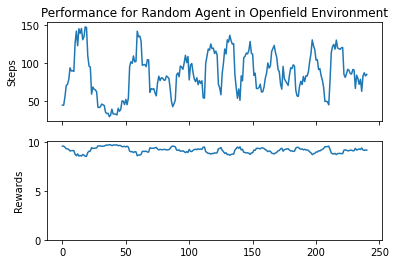

In [95]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(running_mean(open_gw_steps, N=10))
ax[1].plot(running_mean(open_gw_rwds,N=10))
ax[1].set_ylim(-1,10.1)
ax[0].set_ylabel('Steps')
ax[1].set_ylabel('Rewards')
ax[0].set_title('Performance for Random Agent in Openfield Environment')

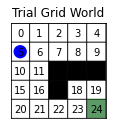

Text(0, 0.5, 'Rewards')

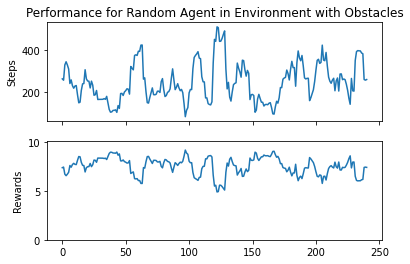

In [97]:
gw_obst = ef.GridWorld(rows=n_rows,cols=n_cols,
                  obstacles=[(2,2),(2,3),(2,4),(3,2)], 
                  rewards={(4,4):10},
                  terminals=[(4,4)],
                  step_penalization=step_penalization,
                  actionlist=['Down','Up','Right','Left'],
                  view_labels=True
                 )

obst_gw_steps,obst_gw_rwds = count_steps_per_episode(gw_obst, random_walker)

## Plot performance 
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(running_mean(obst_gw_steps, N=10))
ax[1].plot(running_mean(obst_gw_rwds,N=10))
ax[1].set_ylim(-1,10.1)
ax[0].set_title('Performance for Random Agent in Environment with Obstacles')
ax[0].set_ylabel('Steps')
ax[1].set_ylabel('Rewards')

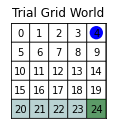

Text(0, 0.5, 'Rewards')

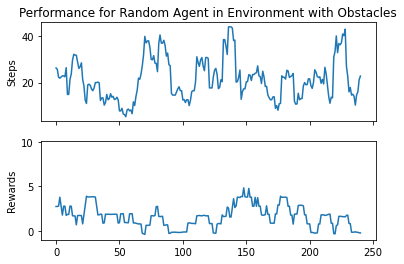

In [100]:
reload(ef)
gw_cliff = ef.GridWorld(rows=n_rows,cols=n_cols,
                  rewards={(4,4):10},
                  terminals=[(n_rows-1,c) for c in range(n_cols)],
                  step_penalization=step_penalization,
                  actionlist=['Down','Up','Right','Left'],
                  view_labels=True
                 )

cliff_gw_steps, cliff_gw_rwds = count_steps_per_episode(gw_cliff, random_walker)

## Plot performance 
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(running_mean(cliff_gw_steps, N=10))
ax[1].plot(running_mean(cliff_gw_rwds,N=10))
ax[1].set_ylim(-1,10.1)
ax[0].set_title('Performance for Random Agent in Environment with Obstacles')
ax[0].set_ylabel('Steps')
ax[1].set_ylabel('Rewards')

Text(0, 0.5, 'Rewards')

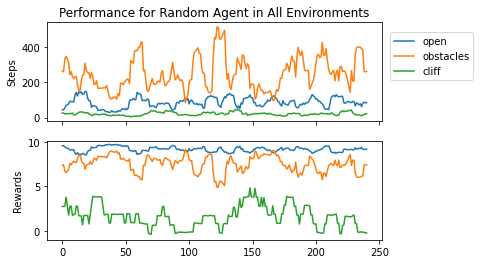

In [101]:
## Plot performance 
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(running_mean(open_gw_steps, N=10),label='open')
ax[0].plot(running_mean(obst_gw_steps, N=10),label='obstacles')
ax[0].plot(running_mean(cliff_gw_steps, N=10),label='cliff')

ax[0].set_title('Performance for Random Agent in All Environments')
ax[0].set_ylabel('Steps')
ax[0].legend(bbox_to_anchor=(1.01,0.95))

ax[1].plot(running_mean(open_gw_rwds,N=10),label='open')
ax[1].plot(running_mean(obst_gw_rwds,N=10),label='obstacles')
ax[1].plot(running_mean(cliff_gw_rwds,N=10),label='cliff')
ax[1].set_ylim(-1,10.1)
ax[1].set_ylabel('Rewards')

#avg_steps = [np.mean(open_gw_steps),np.mean(obst_gw_steps),np.mean(cliff_gw_steps)]
#avg_rwds  = [np.mean(open_gw_rwds),np.mean(obst_gw_rwds),np.mean(cliff_gw_rwds)]


Try changing the step penalization above and rerun these simulations -- see what happens to the reward collected with the random agent in each type of environment. 

# Some larger example environments

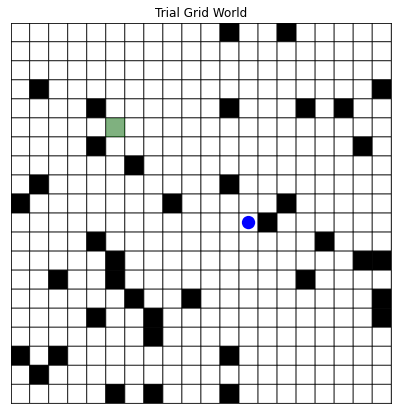

In [16]:
gw_random_obs = ef.GridWorld_random_obstacle()

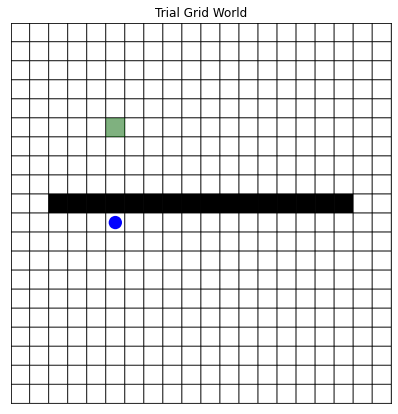

In [17]:
gw_divided = ef.GridWorld_bar()

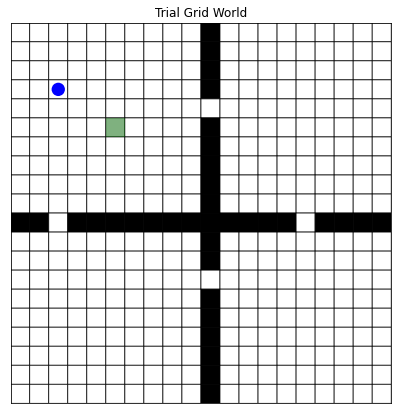

In [18]:
gw_4rooms = ef.GridWorld_4rooms()

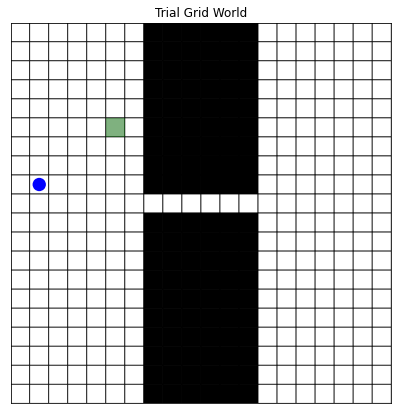

In [19]:
gw_tunnel = ef.GridWorld_tunnel()

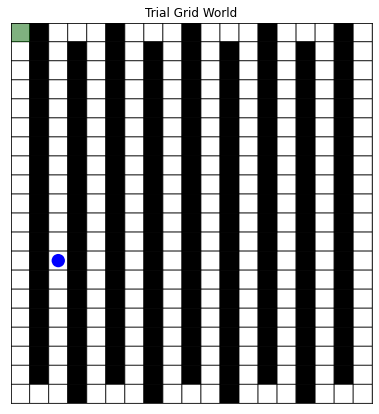

In [20]:
gw_hairpinmaze = ef.GridWorld_hairpin()